In [1]:
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline 

In this notebook, I explore the sample fire dipatch data provided to HACK OR. My first step is to look at length of times between response steps for a given incident (ie time between dispatch to on-scene).

In [9]:
# connect to postgres db on vb

try:
    conn = psycopg2.connect(database='vagrant', user='eruser', password = 'emergency', host='localhost', port='5432')
    print("Opened database successfully")
    
except psycopg2.Error as e:
    print("I am unable to connect to the database")
    print(e)
    print(e.pgcode)
    print(e.pgerror)
    print(traceback.format_exc())

Opened database successfully


In [4]:

def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        #pprint(D)
        #conn.close()
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)
    
   

In [10]:
# look at inctimes table first
QUERY1='''SELECT inctimes.incident_id, inctimes.timedesc_id, inctimes.realtime
FROM fire_dispatch.inctimes
ORDER BY inctimes.incident_id, inctimes.timedesc_id;
'''

In [11]:
df1 = pquery(QUERY1)

SQL QUERY = SELECT inctimes.Incident_ID, inctimes.TimeDesc_ID, inctimes.RealTime
FROM fire_dispatch.inctimes
ORDER BY inctimes.Incident_ID, inctimes.TimeDesc_ID;



In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637845 entries, 0 to 1637844
Data columns (total 3 columns):
incident_id    1637845 non-null int64
timedesc_id    1637845 non-null int64
realtime       1637845 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 37.5 MB


In [13]:
df1.head(15)

,incident_id,timedesc_id,realtime
0,1102989,1,2014-09-22 08:33:03
1,1102989,2,2014-09-22 08:34:16
2,1102989,3,2014-09-22 08:34:33
3,1102989,3,2015-01-19 10:29:50
4,1102989,3,2014-09-22 08:34:33
5,1102989,4,2014-09-22 08:35:41
6,1102989,4,2014-09-22 08:35:41
7,1102989,5,2014-09-22 08:42:43
8,1102989,5,2014-09-22 08:42:43
9,1102989,7,2014-09-22 08:56:03


In [24]:
#Let's audit the data for duplicates. This code shows all rows that have a duplicate pair of incident_id, timedesc_id

df1.duplicated(['incident_id','timedesc_id'],keep = False)

0          False
1          False
2           True
3           True
4           True
5           True
6           True
7           True
8           True
9          False
10          True
11          True
12         False
13         False
14         False
15          True
16          True
17          True
18          True
19          True
20          True
21          True
22          True
23         False
24         False
25         False
26          True
27          True
28         False
29         False
           ...  
1637815    False
1637816     True
1637817     True
1637818     True
1637819    False
1637820    False
1637821    False
1637822     True
1637823     True
1637824     True
1637825     True
1637826     True
1637827     True
1637828     True
1637829     True
1637830    False
1637831    False
1637832    False
1637833    False
1637834     True
1637835     True
1637836    False
1637837    False
1637838     True
1637839     True
1637840    False
1637841     True
1637842     Tr

In [25]:
# print only rows where a duplicate incident_id/timedesc_id pair exists
df1[df1.duplicated(['incident_id','timedesc_id'],keep = False)]

,incident_id,timedesc_id,realtime
2,1102989,3,2014-09-22 08:34:33
3,1102989,3,2015-01-19 10:29:50
4,1102989,3,2014-09-22 08:34:33
5,1102989,4,2014-09-22 08:35:41
6,1102989,4,2014-09-22 08:35:41
7,1102989,5,2014-09-22 08:42:43
8,1102989,5,2014-09-22 08:42:43
10,1102989,12,2014-09-22 08:56:03
11,1102989,12,2015-01-19 10:29:55
15,1102990,3,2014-09-22 08:51:13


Looking at the duplicates above, it seems that the first row is more likely to be the "correct" one. Some events have duplicate timestamps for timedesc_id that are not even in the same year as the first entry, which seems unlikely. For purposes if this analysis, I will treat the first instance of the timedesc_id as correct and ignore the other duplicates. **However, this merits further discussion with the data people at PF&R and more investigation should be made into why duplicates occur and what they might mean.**

In [26]:
# this code does that
df1[df1.duplicated(['incident_id','timedesc_id'],keep = 'first') == False]

,incident_id,timedesc_id,realtime
0,1102989,1,2014-09-22 08:33:03
1,1102989,2,2014-09-22 08:34:16
2,1102989,3,2014-09-22 08:34:33
5,1102989,4,2014-09-22 08:35:41
7,1102989,5,2014-09-22 08:42:43
9,1102989,7,2014-09-22 08:56:03
10,1102989,12,2014-09-22 08:56:03
12,1102990,0,2014-09-22 08:49:54
13,1102990,1,2014-09-22 08:50:08
14,1102990,2,2014-09-22 08:50:56


In [27]:
df1_nd = df1[df1.duplicated(['incident_id','timedesc_id'],keep = 'first') == False]

In [29]:
# this function calculates time deltas for each incident id in the df
# iterating over the groupby object was very helpful

def time_delta(dataframe):
    '''caluclates the time delta between two different timedesc_ids for all groups'''
    count = 0
    group_dict = {}
    for name, group in dataframe.groupby('incident_id'):
        delta_dict = {}
        #print(name)
        #print(group)
        df_t = group.set_index('timedesc_id') # reset the group df to index on timedesc_id
        #print(df_t)
        #print(df_t.loc[3,'realtime'])
        #print(df_t.loc[5,'realtime'])
        #print(df_t.loc[5,'realtime']-df_t.loc[3,'realtime'])
        try:
            #delta3_5 =  df_t.loc[5,'realtime']-df_t.loc[3,'realtime']
            #delta3_10 =  df_t.loc[10,'realtime']-df_t.loc[3,'realtime']
            delta_dict['delta3-5'] = df_t.loc[5,'realtime']-df_t.loc[3,'realtime']
           
        except KeyError:
            delta_dict['delta3-5'] = None
            
        try:
            delta_dict['delta3-10'] =  df_t.loc[10,'realtime']-df_t.loc[3,'realtime']
            
        except KeyError:
            delta_dict['delta3-10'] = None   
        
        group_dict[name] = delta_dict
        
        #count += 1
        #if count == 1:
            #break
    return group_dict
     

In [73]:
# use DataFrame.from_dict method to convert the dictionary object returned in the time_delta function to 
# a pandas df. Note using argument: orient = 'index' makes the dictionary keys into column headers.

#print(time_delta(df1_nd))
time_delta_df = pd.DataFrame.from_dict(time_delta(df1_nd), orient = 'index')
time_delta_df.index.name = 'incident_id'
time_delta_df.head(100)

,delta3-5,delta3-10
incident_id,,
1102989,00:08:10,NaT
1102990,00:04:51,00:33:37
1102991,00:04:30,00:25:31
1102992,00:07:04,NaT
1102993,00:03:10,NaT
1102994,00:04:30,00:47:55
1102995,00:03:10,NaT
1102996,00:04:07,NaT
1102997,00:04:37,NaT


In [74]:
time_delta_df.describe()

,delta3-5,delta3-10
count,101551,57321
mean,0 days 00:06:29.234059,0 days 00:37:45.613300
std,0 days 04:37:30.862114,0 days 01:14:01.817946
min,-15 days +08:47:53,-2 days +17:48:54
25%,0 days 00:03:44,0 days 00:29:16
50%,0 days 00:04:57,0 days 00:36:11
75%,0 days 00:06:26,0 days 00:44:02
max,35 days 10:37:15,12 days 02:37:05


In [75]:
'''
I noticed there are some negative timedelta values which are obviously impossible and should be thrown out.
In addition, pandas cannot plot histgram by just using: time_delta_df.plot()
So we need to do some timedelta conversion to a more easily plotted numerical type.
My approach was to convert the deltas to decimal expression of minutes. This link was helpful:
http://www.datasciencebytes.com/bytes/2015/05/16/pandas-timedelta-histograms-unit-conversion-and-overflow-danger/
'''
print(time_delta_df['delta3-5'].dropna() / pd.Timedelta(minutes=1)) # note that I dropped missing values from the time_delta_df

incident_id
1102989      8.166667
1102990      4.850000
1102991      4.500000
1102992      7.066667
1102993      3.166667
1102994      4.500000
1102995      3.166667
1102996      4.116667
1102997      4.616667
1102998      3.633333
1102999      6.583333
1103000      6.383333
1103001      5.650000
1103002      6.983333
1103003      4.250000
1103004      6.950000
1103005      2.983333
1103006     10.200000
1103007      5.033333
1103008      1.816667
1103009      6.316667
1103010      4.583333
1103011      4.400000
1103012      4.666667
1103013      4.216667
1103014      5.350000
1103016      2.616667
1103017      3.266667
1103018      4.683333
1103019      7.700000
              ...    
1210353      4.850000
1210354      4.950000
1210355      5.533333
1210356      6.016667
1210357      4.566667
1210358      3.166667
1210359      2.083333
1210360     12.066667
1210361     14.283333
1210362      4.016667
1210363     16.233333
1210364     10.616667
1210365      5.566667
1210366     24.58333

In [76]:
# remove null and negative values
# this link was helpful: http://stackoverflow.com/questions/24214941/python-pandas-dataframe-filter-negative-values
clean3_5 = time_delta_df[time_delta_df.loc[:,'delta3-5'] > pd.Timedelta(0)].loc[:,'delta3-5'].dropna()/pd.Timedelta(minutes=1)
clean3_10 = time_delta_df[time_delta_df.loc[:,'delta3-10'] > pd.Timedelta(0)].loc[:,'delta3-10'].dropna()/pd.Timedelta(minutes=1)

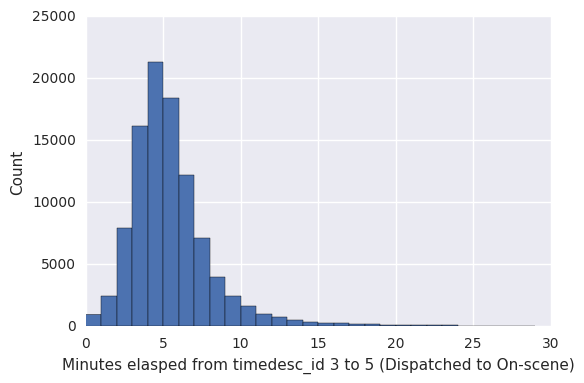

In [86]:
clean3_5.hist(bins=range(0,30,1))
plt.xlabel('Minutes elasped from timedesc_id 3 to 5 (Dispatched to On-scene)')
plt.ylabel('Count')

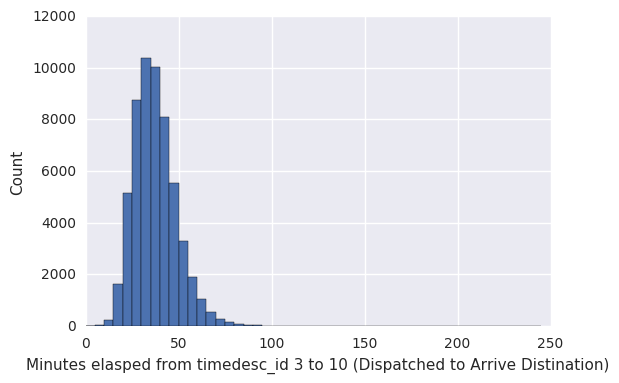

In [87]:
clean3_10.hist(bins=range(0,250,5))
plt.xlabel('Minutes elasped from timedesc_id 3 to 10 (Dispatched to Arrive Distination)')
plt.ylabel('Count')

In [88]:
clean3_5.describe()

count    98746.000000
mean         7.749030
std        252.204602
min          0.016667
25%          3.850000
50%          5.016667
75%          6.483333
max      51037.250000
Name: delta3-5, dtype: float64

In [89]:
clean3_10.describe()

count    57306.000000
mean        37.808421
std         73.626217
min          0.416667
25%         29.283333
50%         36.200000
75%         44.033333
max      17437.083333
Name: delta3-10, dtype: float64

From the histogram and summary statistics above, we can see that the mean response time between dispatch and on-scene is around 7.5 minutes.

For dispatch to arrival destination, the mean time delta is much longer, at 37.8 minutes. 

Both distributions appear normal, and are right skewed which is somewhat expected since outliers cannot exist below 0.

**_1/10/17 Next, if warranted, I can rebuild a summary dataframe with additional time deltas, not just between events 3-5 or 3-10. Not all timedelta pairs can be calculated for each incident id due to missing data, however. We can also look at the data tables to see types of dispatches and what their makeup is._**

In [90]:
# show descriptions of dispatch events as a quick reference
QUERY2='''SELECT * FROM fire_dispatch.timedesc;
  '''

In [91]:
incident_types = pquery(QUERY2)

SQL QUERY = SELECT * FROM fire_dispatch.timedesc;
  


In [92]:
incident_types

,timedesc_id,description,id_911
0,0,Received ...,None
1,1,Initiated ...,None
2,2,Entered ...,ENTRY:
3,3,Dispatched ...,DISP
4,4,Enroute ...,ENROUT
5,5,On Scene ...,ONSCNE
6,6,Fire Under Control ...,None
7,7,Close ...,CLOSE
8,8,With Patient ...,None
9,9,Depart Scene ...,None


In [93]:
conn.close()